# ***Model***


In [ ]:
!pip install gym keras keras-rl2 tensorflow==2.1

      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import os
import pandas as pd 
from datetime import datetime as dt
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
from numpy import loadtxt
from datetime import datetime
from numpy import savetxt
import random ; from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Flatten 
from tensorflow.keras.optimizers import Adam
from rl.policy import * ; from rl.memory import * ; from rl.agents import *
import time
Memoryin_window_length      = 10
window                      = 360
ob_space_Length             = 5
actions                     = 3
MemoryLimit                 = 300000
#----------------------------------------------------------- 
fee                         = 3.0
SL                          = 25.0
TP                          = 25.0


In [ ]:
from google.colab import drive ; drive.mount('/content/drive');os.chdir("/content/drive/MyDrive") 
data = loadtxt('DATA/US30_from2021.csv', delimiter=',' , encoding='utf-16')
prices = data[:,1]
len(prices)

Mounted at /content/drive


105869

In [ ]:
def build_model(ob_space_Length, window, actions,Memoryin_window_length):
    model = Sequential()
    model.add(Dense(128,activation='relu', input_shape=(Memoryin_window_length,ob_space_Length,window) ) )
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions))
    return model    
def build_agent(model, actions,Memoryin_window_length):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit= MemoryLimit , window_length=Memoryin_window_length)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000 ,
                   gamma=0.95 
                  )
    return dqn  
model = build_model(ob_space_Length, window, actions,Memoryin_window_length)
model.summary()
dqn = build_agent(model, actions,Memoryin_window_length)
dqn.compile( Adam(lr=1e-4))    
name  = 'W/WSaveddqn_15-21-22.h5f'
dqn.load_weights(name)   

In [ ]:
def SMAOLD(Data,Periodes):
    n = len(Data)-1 
    res = [Data[0]]
    for i in range(0,n):
      iSMA = 0
      for j in range(i,i+Periodes):
        if(j>=n):
          iSMA = iSMA +Data[n]
        else:
          iSMA = iSMA + Data[j]
      iSMA = iSMA/Periodes  
      res.append(iSMA)
    return res 
def getStats(price_):
  res  = []
  sma5 =  SMAOLD( price_, 5  )
  sma10 = SMAOLD( price_, 10 )
  sma20 = SMAOLD( price_, 20 )
  sma50 = SMAOLD( price_, 50 )
  for i in range(0,len(price_)):
    res.append( [ price_[i] ,sma5[i],sma10[i],sma20[i],sma50[i]  ] )
  res     = np.array(res)  
  ma = res.max()
  mi = res.min()
  res = ( res - mi )/(ma - mi) 
  return res    
def isShortV2( prices ):
  global  TP , SL , fee
  res = -1
  index = 1 
  for i in range(1,len(prices)):
    if( prices[i] <= (prices[0]-TP) ):
      res = TP - fee
      index = i   
      break
    if( prices[i] >= (prices[0]+SL) ):
      res = -SL 
      index = i    
      break
  if( res == -1 ):
    res = 0.1
    index = len(prices)
  return [res , index] 
def ShowReward(nb,AllReward):
  x = []
  y = []
  p = 0
  s = 0
  for i in range(0, len(AllReward)  ):
    if ( AllReward[i] != 0 ):
      s+=AllReward[i]
      x.append(s)
      y.append(p)
      p = p + 1
  k = nb
  l = 0
  if(len(x)>2):
    print( ' All Rewards : {} \n'.format(  x[ len(x)-1 ]  ) )
  for i in range(0,k):
    m = int (len(x)/k )
    x1 = x[ l:(m + m*i) ]
    y1 = y[ l:(m + m*i) ]
    plt.figure(figsize=(16, 9))
    plt.plot( y1, x1, label="US30 Line") 
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.title("Line Graph Example")
    plt.show()  # 200
    l = (m + m*i)    
def isLongV2( prices ):
  global  TP , SL , fee
  res = -1
  index = 1 
  for i in range(1,len(prices)):
    if( prices[i] >= (prices[0]+TP) ):
      res = TP - fee
      index = i 
      break
    if( prices[i] <= (prices[0]-SL) ):
      res = -SL 
      index = i 
      break
  if( res == -1 ):
    res = 0.1
    index = len(prices)
  return [res , index]  
def showTrades( Actions , Prices  ):
  if( Actions[len(Actions)-1][0]<len(Prices) ):
    x1 = Actions[len(Actions)-1][0]
    y1 = Prices[x1]
    print(' ------------> Last Action : {} _  Last Price : {} '.format( y1 , Prices[len(Prices)-1] ))
    plt.figure(figsize=(7, 4)) 
    x = Prices
    y = np.arange(0,len(x) ) 
    plt.plot(  y ,   x   , label="US30 Prices " )
    
    for i in range ( 0 , len( Actions ) ):
      x1 = Actions[i][0]
      y1 = Prices[x1]
      ac = Actions[i][1]
      re = Actions[i][2]
      #rectangle = plt.Rectangle((x1,min), (x2-x1),(max-min) ,facecolor="green", alpha=0.4)
      if(ac==0):
        plt.plot(  x1 , y1 ,  marker='v', markersize=10, color="red") 
        plt.plot(  x1 , y1+TP ,  marker='.', markersize=4, color="maroon")
        plt.plot(  x1 , y1-TP ,  marker='.', markersize=4, color="maroon")
        if( re>0 ):
          plt.annotate('Sell Good '+str(ac)+' = '+str(re), (x1 , y1 + TP/2 ) , color="blue")
        if( re<0 ): 
          plt.annotate('Sell Bad  '+str(ac)+' = '+str(re), (x1 , y1 + TP/2 ) , color="black")
      else:
        plt.plot(  x1 , y1 ,  marker='^', markersize=10, color="darkgreen") 
        plt.plot(  x1 , y1+TP ,  marker='.', markersize=4, color="green")
        plt.plot(  x1 , y1-TP ,  marker='.', markersize=4, color="green")
        if( re>0 ):
          plt.annotate('Buy Good '+str(ac)+' = '+str(re), (x1 , y1 + TP/2 ), color="blue")
        if( re<0 ) :
          plt.annotate('Buy Bad '+str(ac)+' = '+str(re), (x1 , y1 + TP/2 ), color="black")
      #plt.annotate('Close Win at : '+str(y2), (x2 , y2 - self.TP/2 ))
      #plt.gca().add_patch(rectangle)
    plt.show()
class envLive(Env ):
    def __init__(self,  subPrices_ , DayStats_ ,tp_,sl_, saveRewards):
         #------------  observation_space  observation_space --------------------------------------------
        global ob_space_Length , window  , fee , AllReward
        self.window = window   # 360Min = 6H (Best View) 
        self.observation_space = Box(low= 0.0, high= 1.0, shape=( ob_space_Length ,self.window), dtype=np.float64 )
        self.action_space = Discrete(3)
 
        #------------  Parameters --------------------------------------------
        self.DayStep =  1300 #1380
        self.DayStats  = DayStats_ 
        self.subPrices  = subPrices_
        self.iwin = 0               # iWindow [ 0 - (length_data - window ) ]
        self.SL = sl_
        self.TP = tp_
        self.info_ = {}
        self.saveRewards = saveRewards

        self.arrActions = []
        self.nbTrades = 0

          
 
    def step(self, action):
        reward = 0
        done = False
        arrOfPrice = self.subPrices[( self.window + self.iwin ):len( self.subPrices )]

        if(action==0):# sell
          reward , index = isShortV2( arrOfPrice  )
          self.iwin+=index
          self.nbTrades+=1
          self.arrActions.append( [ self.window + self.iwin - index , action , reward ] )

        if(action==1):# Buy
          reward , index = isLongV2( arrOfPrice  )
          self.iwin+=index
          self.nbTrades+=1
          self.arrActions.append( [ self.window + self.iwin - index , action , reward ] )

        if(action==2 ):# none
          reward = 0
          self.iwin = self.iwin + 1

        if( reward == 0.1 ):
          done = True 
          return self.state, reward, done, self.info_

        # Check if shower is done
        if ( (self.iwin+self.window) >  len(self.DayStats)   ):
            done = True
        else:
            i1 = self.iwin
            i2 = self.window + self.iwin
            self.state = np.transpose( self.DayStats[i1:i2] )

        if(self.saveRewards==1):
          AllReward.append(reward)
        return self.state, reward, done, self.info_
    def render(self):
       r=0
    def reset(self):
        self.iwin = 0
        i1 = self.iwin
        i2 = self.window + self.iwin
        
        self.state = np.transpose( self.DayStats[i1:i2]  )
        return self.state

# ***Live***

In [ ]:
def show1(  Prices  ):
  plt.figure(figsize=(5, 3)) 
  x = Prices
  y = np.arange(0,len(x) ) 
  plt.plot(  y ,   x   , label="US30 Prices " )
  plt.plot(  y[len(y)-1] , x[len(x)-1],  marker='*', markersize=10, color="darkgreen") 
  plt.show()

In [ ]:
window_Live = 20
start = 2000
end   = 2010
while( start <=end ):
  Price = prices[ (start-window_Live):start ]
  show1(  Price  )

  time.sleep(1)
  start+=1

In [ ]:
class Amine30():
   def __init__(self, initialData , getRewards ):
     if( len(initialData)<1300 ):
       print( 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' )
       print( ' initial Data It should be a day or more (1300 Bars) ' )
       print( 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' )
     self.initialData = initialData[ (len(initialData)-1300):(len(initialData)) ] 
     self.DayStats  = getStats( self.initialData )
     self.env = envLive(    self.initialData , self.DayStats , TP, SL,getRewards)
     self.actions = []
     _ = dqn.test(self.env, nb_episodes=1  , visualize=False)

   def add(self, NewPrice):
     print( ' price add {} '.format( NewPrice ) ) 
     self.initialData = np.append ( self.initialData , [NewPrice])
     self.initialData = np. delete(self.initialData,0 )
     self.DayStats  = getStats( self.initialData )
     self.env = envLive(    self.initialData , self.DayStats , TP, SL,getRewards)
     _ = dqn.test(self.env, nb_episodes=1  , visualize=False)
     self.actions = self.env.arrActions

   def printf1(self,long):
     print( ' initialData[{}]={}  '.format( long,self.initialData[ (len(self.initialData)-long):(len(self.initialData)) ]  ) )   
   def printf2(self,long):
     res = self.initialData[ (len(self.initialData)-long):(len(self.initialData)) ] 
     show1( res )  
   def printfActions(self,long):
     res = self.initialData[ (len(self.initialData)-long):(len(self.initialData)) ] 
     ac = self.actions[ (len(self.actions)-long):(len(self.actions)) ]
     '''start_ = len(self.initialData) - long
     newAction = []
     for i in range(0,len(ac)):
       if(ac[i][0]>=start_):
         ac[i][0] = ac[i][0] - start_
         newAction.append( ac[i] )
     ''' 
     showTrades( self.actions,rself.initialDataes ) 

In [ ]:
window_Live = 20
Day_steps   = 1300
getRewards  = 0
start = 9000
end   = 2010
Price = prices[ (start-Day_steps):start ]
car = Amine30(Price,getRewards) 
for i in range( 0 ,10):
  car.add(prices[start+i]) 
  car.printfActions(50)


Testing for 1 episodes ...
Episode 1: reward: 320.100, steps: 81
 price add 31008.0 
Testing for 1 episodes ...
Episode 1: reward: 464.100, steps: 74
[[1250, 0, 22.0], [1260, 1, -25.0], [1272, 1, -25.0], [1277, 1, 22.0], [1281, 1, 0.1]]
 PriceLastTrade[1281]=31004.0  
 Price Now ----------> =31008.0  
 price add 31009.0 
Testing for 1 episodes ...
Episode 1: reward: 464.100, steps: 74
[[1249, 0, 22.0], [1259, 1, -25.0], [1271, 1, -25.0], [1276, 1, 22.0], [1280, 1, 0.1]]
 PriceLastTrade[1280]=31004.0  
 Price Now ----------> =31009.0  
 price add 31017.0 
Testing for 1 episodes ...
Episode 1: reward: 464.100, steps: 74
[[1248, 0, 22.0], [1258, 1, -25.0], [1270, 1, -25.0], [1275, 1, 22.0], [1279, 1, 0.1]]
 PriceLastTrade[1279]=31004.0  
 Price Now ----------> =31017.0  
 price add 31013.0 
Testing for 1 episodes ...
Episode 1: reward: 464.100, steps: 74
[[1247, 0, 22.0], [1257, 1, -25.0], [1269, 1, -25.0], [1274, 1, 22.0], [1278, 1, 0.1]]
 PriceLastTrade[1278]=31004.0  
 Price Now ------

Testing for 1 episodes ...
Episode 1: reward: 522.100, steps: 168
 All Rewards : 522.0 



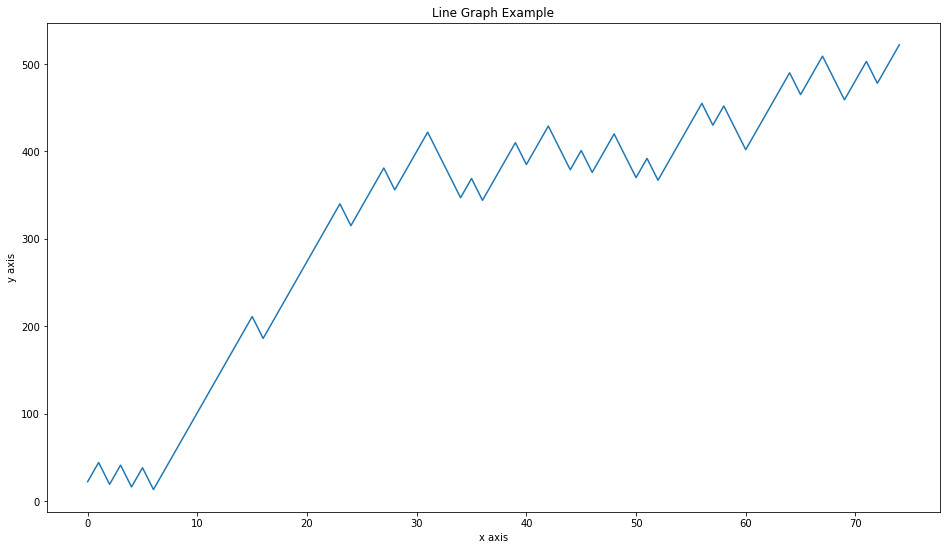

In [ ]:
AllReward   = []
sIndex                        = 0 
eIndex                        = 200000
startIndex  = sIndex
AllTrade = 0
for k in range(0,1):
  d1 = sIndex
  d2 = d1 + 1300 + k 
  subPrices = prices[d1:d2]
  DayStats  = getStats( subPrices ) 
  TargetGuests = len(DayStats)
  #print( TargetGuests )
  env = envLive(    subPrices , DayStats , TP, SL,1)
  _ = dqn.test(env, nb_episodes=1  , visualize=False)
  actions = env.arrActions 
ShowReward(1,AllReward)